# Artificial Neural Networks
In this exercise, several parts of the code are missing, which should be completed by you. 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import sklearn
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn.metrics import accuracy_score
sns.set()

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

## MLP for Skin disease dataset using `scikit-learn`

Now let us apply a neural network on the skin disesase data. To reduce the training time we reduce the amount of data in our dataset.

In [9]:
df = pd.read_csv("skin_disease.csv")
df = df.sample(frac=1, random_state=42)
df = df.iloc[0:100000]
df.head()

,class,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13
104241,0,0.0,1.0,145.773346,139.724564,107.318260,1.010547,1.503807,9.321437,0.774784,1.226741,3.429569,1.361153,2.040051,10.930368
199676,0,0.0,1.0,145.853653,147.327774,139.264130,1.454444,2.466479,9.787168,-1.076918,-1.048572,7.805043,1.810385,3.022373,11.980303
140199,0,0.0,1.0,146.028549,143.828674,147.055923,1.228898,1.569462,5.651738,0.722707,0.840090,3.232289,1.601107,2.128853,7.526801
132814,0,0.0,1.0,146.447357,141.013687,137.269485,1.653434,1.750785,6.906916,0.904493,1.496825,-5.599911,1.977242,2.351642,8.867031
408697,0,0.0,1.0,146.090424,141.610352,149.331345,1.111900,1.200778,4.456708,-0.187116,-0.395872,2.748191,1.430844,1.626119,6.113576


In [10]:
X = df.drop(columns=["class"])
y = df["class"]

> Split the data into a train and test set. Use 40% of the data for the test set.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

We define our Multi Layer Perceptron with 2 hidden layers. This time we use the [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) implementation from Scikit-Learn.

In [12]:
mlp = MLPClassifier(hidden_layer_sizes=(30,15),
                    activation='relu',  # activation function
                    solver='adam',  # optimizer
                    batch_size=1024)  # size of minibatches

> Train the neural network on `X_train`, `y_train` and plot the loss by accessing the attribute `loss_curve_`.

In [14]:
def plot_costs(costs):
    fig, ax = plt.subplots()
    ax.plot(costs)
    ax.set_title("Loss curve")
    plt.show()

In [55]:
mlp.out_activation_

'logistic'

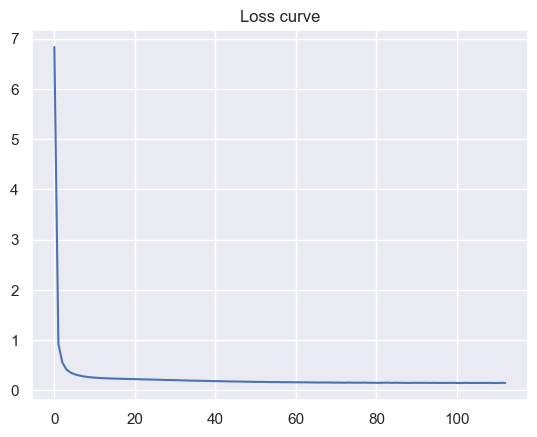

In [15]:
mlp.fit(X_train, y_train)
plot_costs(mlp.loss_curve_)

> Implement your own predict function. For that we'll need an activation function for the hidden layers, in our case `relu` and for the output layer `sigmoid`.

In [16]:
def relu(x):
    return np.maximum(0, x)

In [17]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [31]:
def predict(mlp, X):
    # define the first activations, e.g. inputs
    A = X

    # forward propagate through layers
    for i, (W, B) in enumerate(zip(mlp.coefs_, mlp.intercepts_)):
        z = np.dot(A, W) + B
        # if hidden layer (not output layer), apply `relu`
        if i != mlp.n_layers_ - 2:
            A = relu(z)

    # last layer output activation `sigmoid`
    o = sigmoid(z)
    # transform to 1-D and threshold
    o = np.squeeze(o)
    o = np.array(o > 0.5, dtype=int)

    return o

> Test your implementation with the scikit-learn predict function.

In [32]:
y_pred_scikit = mlp.predict(X_test)
y_pred_own = predict(mlp, X_test)

print('Are the outputs the same: %s' % (y_pred_scikit == y_pred_own).all() )

Are the outputs the same: True


> Predict the values on the test set and calculate the accuracy and the f1-score.

In [36]:
accuracy = accuracy_score(y_pred_own, y_test)
f1 = f1_score(y_pred_own, y_test)
print(f"accuracy: {accuracy}; f1 score = {f1}")

accuracy: 0.9428; f1 score = 0.6214427531436134


## MLP for Skin disease dataset using `TensorFlow`
In practice, the MLP from `scikit-learn` is never used because of the lack of customisation and the absence of GPU training. `TensorFlow` is a library specialised in deep learning and therefore also has implementations for advanced techniques. Thus the section below is a quick introduction to how the same network can be implemented using `TensorFlow`. The networks' results do not need to be the same, since as mentioned above, the `scikit-learn` implementation can not be as customised as the `TensorFlow` one. 

In [38]:
import tensorflow as tf

A model in `TensorFlow` can be implemented using the `Sequential API`, which enables for easy extensibility by calling `.add()`. To implement the same MLP as above, we can sequentially add `Dense` layers to the model. Here the customization possibilities compared to `scikit-learn` is evident. For example, the activation function can be set for each layer separately, which was impossible before.

In [39]:
dataset_dim = X_train.shape[1]

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(30, input_shape=(dataset_dim, ), activation='relu'))
model.add(tf.keras.layers.Dense(15, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                450       
                                                                 
 dense_1 (Dense)             (None, 15)                465       
                                                                 
 dense_2 (Dense)             (None, 1)                 16        
                                                                 
Total params: 931
Trainable params: 931
Non-trainable params: 0
_________________________________________________________________


After defining the model, it needs to be compiled using an optimizer and loss function. In our case, we'll use adam as optimizer and binary cross-entropy as loss. Now the model can be trained by specifying the number of epochs and the batch size. 

In [51]:
adam = tf.keras.optimizers.Adam()
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=1024, epochs=150) 

Epoch 1/150
59/59 [==============================] - 0s 1ms/step - loss: 0.1171 - accuracy: 0.9518
Epoch 2/150
59/59 [==============================] - 0s 1ms/step - loss: 0.1049 - accuracy: 0.9569
Epoch 3/150
59/59 [==============================] - 0s 1ms/step - loss: 0.1066 - accuracy: 0.9562
Epoch 4/150
59/59 [==============================] - 0s 1ms/step - loss: 0.1107 - accuracy: 0.9544
Epoch 5/150
59/59 [==============================] - 0s 1ms/step - loss: 0.1076 - accuracy: 0.9560
Epoch 6/150
59/59 [==============================] - 0s 1ms/step - loss: 0.1067 - accuracy: 0.9563
Epoch 7/150
59/59 [==============================] - 0s 1ms/step - loss: 0.1080 - accuracy: 0.9556
Epoch 8/150
59/59 [==============================] - 0s 1ms/step - loss: 0.1061 - accuracy: 0.9566
Epoch 9/150
59/59 [==============================] - 0s 1ms/step - loss: 0.1071 - accuracy: 0.9563
Epoch 10/150
59/59 [==============================] - 0s 1ms/step - loss: 0.1069 - accuracy: 0.9565
Epoch 11/

We can also plot the loss curve using the same function as above.

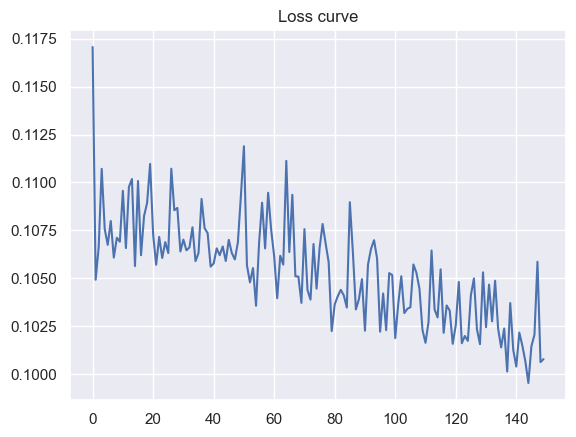

In [52]:
plot_costs(history.history["loss"])

The model can also be evaluated on the test set with familiar code.

In [53]:
y_pred = model.predict(X_test)
y_pred = np.array(y_pred > 0.5, dtype=int).squeeze()

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: %.4f" % accuracy)
print("F1: %.4f" % f1)

1250/1250 [==============================] - 1s 567us/step
Accuracy: 0.9565
F1: 0.7194


# Assignment

> Now answer the Ilias Quiz 08A Neural Networks - Notebook Verification